## Task

In this task, we will try to do sentiment analysis using both images and text. Sounds fun, right!

We have the dataset [MVSA: Sentiment Analysis on Multi-view Social Data](https://mcrlab.net/research/mvsa-sentiment-analysis-on-multi-view-social-data/) which is a collection of tweets which include both text and images.

Your job is the following:
1. Read and process the dataset (images, text, and their labels) and divide into train and test dataset (80:20 split).
2. Build, train and evaluate a CNN which only uses images for sentiment analysis
3. Build, train and evaluate a Text model which only uses the text data for sentiment analalysis (You can use any of RNN/LSTM/GRU)
4. Build, train and evaluate a combined model which uses both visual aand text data.
5. Do a performance comparsion of these three different kinds of models. Also plot confusion matrices for all of them.

Here's how the combined model would look like.

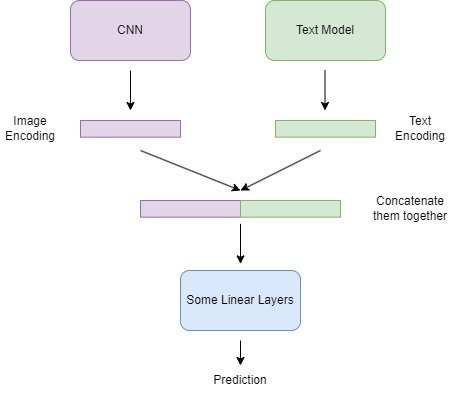

In [ ]:
!gdown "1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH"

Downloading...
From (original): https://drive.google.com/uc?id=1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH
From (redirected): https://drive.google.com/uc?id=1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH&confirm=t&uuid=953a85b0-7dd7-4b27-9e67-a55086f81c8c
To: /content/MVSA-Single.zip
100% 211M/211M [00:01<00:00, 118MB/s]


In [ ]:
!unzip MVSA-Single.zip

Archive:  MVSA-Single.zip
replace MVSA_Single/data/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
from IPython.display import clear_output

In [ ]:
import os

import torch
import torch.nn as nn

#import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms.functional import to_tensor
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from PIL import Image, ImageOps

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [ ]:
labels_df = pd.read_csv('MVSA_Single/labelResultAll.csv')
print(labels_df)

        ID     label
0        1  positive
1        2  positive
2        3  positive
3        4  positive
4        5  positive
...    ...       ...
4864  5125  positive
4865  5126   neutral
4866  5127  positive
4867  5128  positive
4868  5129  positive

[4869 rows x 2 columns]


**Check if all labels have both image and text attached to them**

In [ ]:
data_directory = 'MVSA_Single/data/'

def check_files_exist(id):
    img_path = os.path.join(data_directory, f"{id}.jpg")
    txt_path = os.path.join(data_directory, f"{id}.txt")
    return os.path.exists(img_path) and os.path.exists(txt_path)

# Apply the check to each ID in the labels file
labels_df['files_exist'] = labels_df['ID'].apply(check_files_exist)

# Check if any label does not have both files
missing_files = labels_df[~labels_df['files_exist']]

if missing_files.empty:
    print("All labels have both an image and a text file.")
else:
    print(f"Some labels are missing files: {missing_files['ID'].tolist()}")

All labels have both an image and a text file.


**Creating custom image dataset**

**Create DataFrame with labels and paths to images**

In [ ]:
csv_file_path = 'MVSA_Single/labelResultAll.csv'
data_dir_path = 'MVSA_Single/data'

img_paths = []
labels_num = []
labels = []

txt_paths = []

for index, row in labels_df.iterrows():
    image_id = row['ID']
    label = row['label']

    if label == 'positive':
      numerical_label = 0
    elif label == 'negative':
      numerical_label = 1
    elif label == 'neutral':
      numerical_label = 2
    else:
      numerical_label = -1

    # Construct the expected filename for the image
    img_filename = f'{image_id}.jpg'
    txt_filename = f'{image_id}.txt'

    # Construct the full path to the image file
    full_path_img = os.path.join(data_dir_path, img_filename)
    full_path_txt = os.path.join(data_dir_path, txt_filename)

    if os.path.isfile(full_path_img):
      img_paths.append(full_path_img)
      labels_num.append(numerical_label)
      labels.append(label)

    if os.path.isfile(full_path_txt):
      txt_paths.append(full_path_txt)

# Create a new DataFrame with the image paths and labels
df_images = pd.DataFrame({
    'img_path': img_paths,
    'label': labels
})

# Create a new DataFram with text paths and labels
df_texts = pd.DataFrame({
    'txt_path': txt_paths,
    'label': labels
})

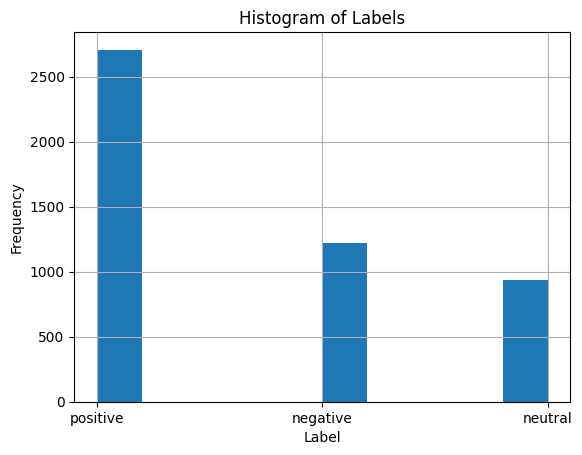

In [ ]:
# Plotting the histogram
df_images['label'].hist()
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Histogram of Labels')
plt.show()

**Comment**

We can see from the histogram above that the data set has got a lot of 'positive' labels whereas the rest of the labels are much less in size.

**Sanity Checks**

In [ ]:
df_images.head()

,img_path,label
0,MVSA_Single/data/1.jpg,positive
1,MVSA_Single/data/2.jpg,positive
2,MVSA_Single/data/3.jpg,positive
3,MVSA_Single/data/4.jpg,positive
4,MVSA_Single/data/5.jpg,positive


In [ ]:
df_texts.head()

,txt_path,label
0,MVSA_Single/data/1.txt,positive
1,MVSA_Single/data/2.txt,positive
2,MVSA_Single/data/3.txt,positive
3,MVSA_Single/data/4.txt,positive
4,MVSA_Single/data/5.txt,positive


**Histogram of images size**

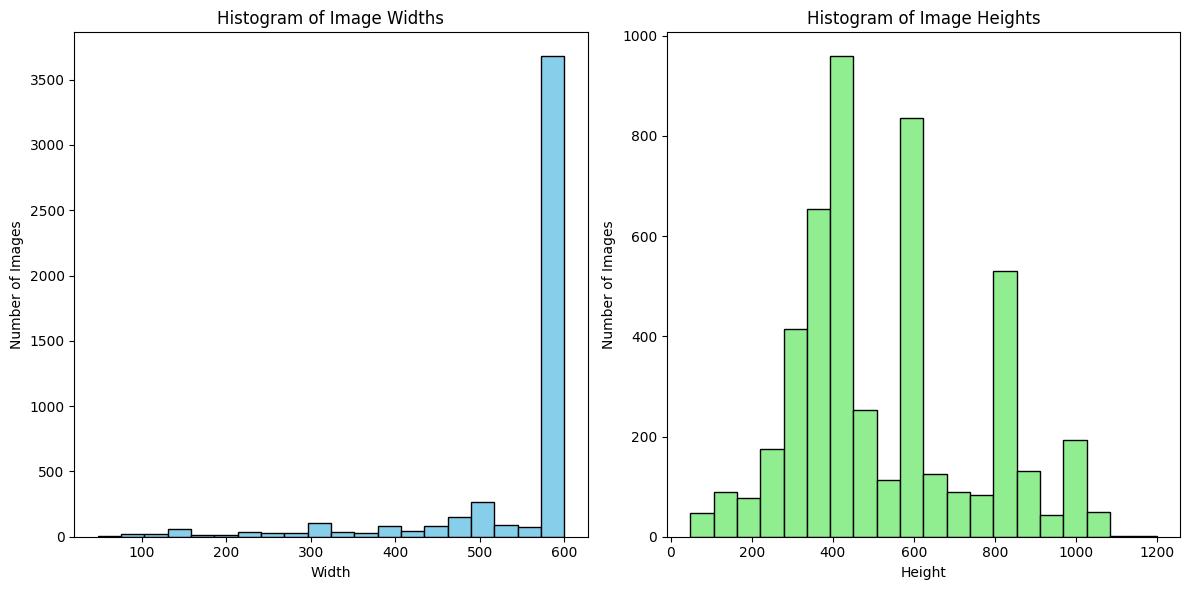

In [ ]:
widths = []
heights = []
for _, row in df_images.iterrows():
    path = row['img_path']
    with Image.open(path) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Plotting the histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Image Widths')
plt.xlabel('Width')
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='lightgreen', edgecolor='black')
plt.title('Histogram of Image Heights')
plt.xlabel('Height')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

**DataFrame with labels and paths to images to csv**

In [ ]:
# Assuming 'labels' contains the original categorical labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # Convert categorical labels to numerical

# Calculate class weights for imbalance handling
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# One-hot encode the labels in the DataFrame
df_images = pd.get_dummies(df_images, columns=['label'])
df_texts = pd.get_dummies(df_texts, columns=['label'])

# Print or use the class weights as needed
print("Class weights:", class_weights_dict)

Class weights: {0: 1.3270645952575633, 1: 1.7302771855010661, 2: 0.5993353028064993}


In [ ]:
print(df_images.head())

                 img_path  label_negative  label_neutral  label_positive
0  MVSA_Single/data/1.jpg           False          False            True
1  MVSA_Single/data/2.jpg           False          False            True
2  MVSA_Single/data/3.jpg           False          False            True
3  MVSA_Single/data/4.jpg           False          False            True
4  MVSA_Single/data/5.jpg           False          False            True


In [ ]:
print(df_texts.head())

                 txt_path  label_negative  label_neutral  label_positive
0  MVSA_Single/data/1.txt           False          False            True
1  MVSA_Single/data/2.txt           False          False            True
2  MVSA_Single/data/3.txt           False          False            True
3  MVSA_Single/data/4.txt           False          False            True
4  MVSA_Single/data/5.txt           False          False            True


In [ ]:
df_images.to_csv("images_labels.csv", index=False)

In [ ]:
df_texts.to_csv("texts_labels.csv", index=False)

**Custom dataset class**

**Dataset class for images**

In [ ]:
class MyCustomDataset(Dataset):
    def __init__(self, labels_file_path, transforms=None):
        super().__init__()
        self.labels_file_path = labels_file_path
        self.labels = pd.read_csv(self.labels_file_path)
        self.transform_funcs = transforms

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.labels.iloc[idx, 0]  # Assuming the first column is 'img_path'
        # Assuming the rest of the columns are one-hot encoded labels
        label = self.labels.iloc[idx, 1:].values.astype('float32')
        label = torch.tensor(label)

        img = Image.open(img_path)
        if self.transform_funcs:
            img = self.transform_funcs(img)

        return img, label

**Resize images to 300*300 pixels and convert them to tensors**

In [ ]:
trans = transforms.Compose([
        transforms.Resize((300,300)),
        transforms.ToTensor()
    ])
my_image_dataset = MyCustomDataset("/content/images_labels.csv", trans)

In [ ]:
len(my_image_dataset)

4869

In [ ]:
my_dataloader = DataLoader(my_image_dataset, batch_size=4)

**Split to testing and training sets**

In [ ]:
total_size = len(my_image_dataset)
train_size = int(total_size * 0.8)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(my_image_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

for images, labels in test_loader:
    print("Images shape:", images.shape)
    print("Labels:", labels)
    print(labels.shape)
    print(labels)
    # Optionally, visualize the first image in the batch
    # If you're running in a Jupyter notebook or similar, you can use matplotlib:
    # import matplotlib.pyplot as plt
    # plt.imshow(images[0].permute(1, 2, 0))  # Assuming images are in CxHxW format
    # plt.title(f"Label: {labels[0]}")
    # plt.show()
    break

print(len(train_loader))
print(len(test_loader))

Images shape: torch.Size([4, 3, 300, 300])
Labels: tensor([[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.]])
torch.Size([4, 3])
tensor([[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.]])
974
244


**CNN PyTorch Implementation**

In [ ]:
class OurCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Reduced number of filters
        self.conv_layer_1 = nn.Conv2d(in_channels=3, out_channels=70, kernel_size=3, padding=1)
        self.conv_layer_2 = nn.Conv2d(in_channels=70, out_channels=35, kernel_size=3, padding=1)
        # Removed one convolutional layer

        # Pooling layer remains the same
        self.pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adjusted linear layer to match new output size, assuming image size of 400x400
        # This needs to be recalculated based on the actual output size after pooling
        self.linear_layer_1 = nn.Linear(in_features=35 * 75 * 75, out_features=100)
        self.linear_layer_2 = nn.Linear(in_features=100, out_features=3)

    def forward(self, x, return_features=False):
        x = self.pool_layer(F.relu(self.conv_layer_1(x)))
        x = self.pool_layer(F.relu(self.conv_layer_2(x)))

        x = x.flatten(start_dim=1)
        if return_features:
          return x

        x = F.relu(self.linear_layer_1(x))
        x = self.linear_layer_2(x)

        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
class_weights_tensor = torch.FloatTensor(list(class_weights_dict.values())).to(device)
model = OurCNN().to(device)

optimizer = Adam(model.parameters(), lr=1e-5)
#criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
criterion = nn.CrossEntropyLoss()

**Comment**

Tried to deal with the inbalance in the data with using weights for each data point but it didn't seem to help with the accuracy of the model.

**Training**

In [ ]:
num_epochs = 5

epoch_training_loss = []

for i in range(num_epochs):
  batch_losses = 0
  for x,y in train_loader:
    x = x.to(device)
    y = y.to(device)

    out = model(x)

    loss = criterion(out, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batch_losses += loss.item()

  epoch_training_loss.append(batch_losses/len(train_loader))
  print(f"Epoch: {i}, training_loss: {epoch_training_loss[-1]}")

Epoch: 0, training_loss: 0.9927521021520332
Epoch: 1, training_loss: 0.9767971079819501
Epoch: 2, training_loss: 0.9635198543448713
Epoch: 3, training_loss: 0.9472134448052432
Epoch: 4, training_loss: 0.9326566409097805


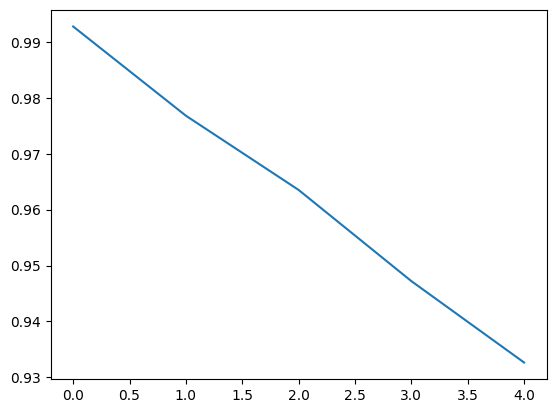

In [ ]:
plt.plot(epoch_training_loss)

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0  # Total number of samples processed
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)  # Keep y on the device for comparison

        out = model(x)
        _, preds = torch.max(out, 1)
        # Convert one-hot encoded labels back to class indices for comparison
        _, labels_indices = torch.max(y, 1)

        correct += (preds == labels_indices).sum().item()
        total += y.size(0)

    accuracy = (correct / total) * 100
    print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 56.365503080082135%


In [ ]:
y_true = []
y_pred = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        _, preds = torch.max(out, 1)

        # Assuming y is one-hot encoded, convert it to class indices
        _, labels_indices = torch.max(y, 1)

        y_true.extend(labels_indices.cpu().numpy())  # Collect true labels as class indices
        y_pred.extend(preds.cpu().numpy())  # Collect predictions

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[  0   0 246]
 [  0   0 179]
 [  0   0 549]]


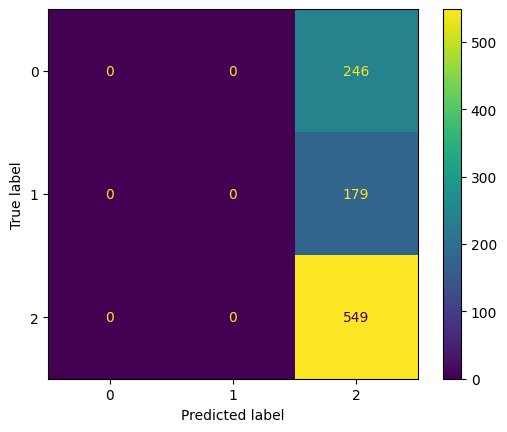

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

**Comment**

It is clear from the confusion matrix that the model is learning to classify all data from testing set to the 'positive' category. Indeed this is not the expected behaviour. Dealing with inbalance in the data through the calculation of weights was attempted but unfortunately this approach did not improve the performance or the accuracy of the model.

**Text Classification**

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from functools import partial
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
def read_text(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='ISO-8859-1') as file:
            return file.read()

# Assuming df_texts is your DataFrame with 'txt_path' and 'label' columns
# Read the text content from files
df_texts['text'] = df_texts['txt_path'].apply(read_text)

# Create a new DataFrame with only 'text' and 'label' columns
df_final_texts = df_texts[['text', 'label_negative', 'label_neutral', 'label_positive']]

In [ ]:
print(df_final_texts.head())

                                                text  label_negative  \
0    How I feel today #legday #jelly #aching #gym \n           False   
1  grattis min griskulting!!!???? va bara tvungen...           False   
2  RT @polynminion: The moment I found my favouri...           False   
3  #escort We have a young and energetic team and...           False   
4  RT @chrisashaffer: Went to SSC today to be a "...           False   

   label_neutral  label_positive  
0          False            True  
1          False            True  
2          False            True  
3          False            True  
4          False            True  


In [ ]:
## retain only text that contain less that 70 tokens to avoid too much padding
df_final_texts["token_size"] = df_final_texts["text"].apply(lambda x: len(x.split(' '))) # adds number of words(tokens) of each sentence
data = df_final_texts.loc[df_final_texts['token_size'] < 70].copy() # new data frame with sentences only consisting of less than 70 words(tokens)

## sampling; we don't need to use the entire data as we only want to show you
## the tokenization/batch preparation process
data = data.sample(n=4869, replace=False); # sample only 50000 of those sentences

print(data.head(10))

                                                   text  label_negative  \
3174  RT @cali4niagurl84: A beautiful day go out & u...           False   
1681  Blog Post: #VivaBianca #Scorned #NudeScene #Sh...           False   
1918  umbrella has arrived. now to actually like... ...            True   
3895  480/70-30 BLEMISHED INDUSTRIAL 158/PLY TIRE ht...            True   
435   New Womens CHAUS Short Sleeve Black White Lace...           False   
1374  @AVFCBlog @oldmansaid @JackWoodwardAV @StanCol...            True   
814   He had no #failings which were not owing to a ...           False   
2049  UNHEATED IF~1.16CT/2p ROUND 4.70mm DIAMOND CUT...           False   
1120  Atelier Cushion Festival - 13th February 2015....           False   
2538  RT @SarahDerkum: His two year death anniversar...           False   

      label_neutral  label_positive  token_size  
3174          False            True          28  
1681          False            True          11  
1918          False     

In [ ]:
## This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa
## (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))

        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0

        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token

        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [ ]:
## construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

inputs.vocab[0:10]

['',
 '\n',
 '!',
 '!!',
 '!!!',
 '!!!!',
 '!!!!!!',
 '!!/):&3\'wH!2@"0hGrw$]+?=_=%-$#_+\'el',
 '"',
 '""impotent""']

In [ ]:
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [ ]:
input_tensor[0:2]

[[14261,
  8119,
  9252,
  16838,
  17917,
  19177,
  22687,
  4793,
  25188,
  16123,
  244,
  3822,
  3725,
  2143,
  21215,
  25109,
  23321,
  22556,
  17199,
  24795,
  22097,
  13606,
  15831,
  10269,
  18871,
  24464,
  21151,
  2],
 [9956, 14069, 2187, 1865, 1567, 1900, 965, 2085, 1688, 496, 2]]

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_inp = max_length(input_tensor)
print(max_length_inp)

def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

30


In [ ]:
data[0:2]

,text,label_negative,label_neutral,label_positive,token_size
3174,RT @cali4niagurl84: A beautiful day go out & u...,False,False,True,28
1681,Blog Post: #VivaBianca #Scorned #NudeScene #Sh...,False,False,True,11


**Split the data**

In [ ]:
target_tensor = data[['label_negative', 'label_neutral', 'label_positive']].values

# Splitting the data into training and validation sets
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)

# Further split the validation set to obtain a test set
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5, random_state=42)


In [ ]:
## Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

## Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

## Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(3895, 3895, 487, 487, 487, 487)

In [ ]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64

TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len

    def __len__(self):
        return len(self.data)

In [ ]:
## Dataset instance
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)


## Data Loader instance
train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                     drop_last=True,
                     shuffle=True)

val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE,
                     drop_last=True,
                     shuffle=True)

test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                     drop_last=True,
                     shuffle=True)

**RNN**

In [ ]:
class EmoRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoRNN, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size

        ## layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5) # avoid overfitting
        self.rnn = nn.RNN(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)

    def initialize_hidden_state(self):
        return torch.zeros(1, self.batch_sz, self.hidden_units)

    def forward(self, x, lens):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state().to(x.device)
        output, self.hidden = self.rnn(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden

In [ ]:
# parameters
TRAIN_BUFFER_SIZE = 40000 # len(input_tensor_train)
VAL_BUFFER_SIZE = 5000 # len(input_tensor_val)
TEST_BUFFER_SIZE = 5000 # len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = 3 # num_emotions

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
## Enabling cuda
model = EmoRNN(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

## loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    ## convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target)
    return loss

def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0

    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        inp = inp.permute(1 ,0).to(device)
        predictions, _ = model(inp, lens)

        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy

        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))

    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):
        predictions,_ = model(inp.permute(1, 0).to(device), lens)
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy

    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1,
                                                             total_loss / TRAIN_N_BATCH,
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3708
Epoch 1 Loss 0.0361 -- Train Acc. 4.8000 -- Val Acc. 4.5272
Time taken for 1 epoch 1.575307846069336 sec

Epoch 2 Batch 0 Val. Loss 0.3591
Epoch 2 Loss 0.0339 -- Train Acc. 4.9550 -- Val Acc. 4.4671
Time taken for 1 epoch 0.60666823387146 sec

Epoch 3 Batch 0 Val. Loss 0.3265
Epoch 3 Loss 0.0341 -- Train Acc. 4.9775 -- Val Acc. 3.8061
Time taken for 1 epoch 0.6021246910095215 sec

Epoch 4 Batch 0 Val. Loss 0.3494
Epoch 4 Loss 0.0336 -- Train Acc. 5.0450 -- Val Acc. 4.6675
Time taken for 1 epoch 0.6017403602600098 sec

Epoch 5 Batch 0 Val. Loss 0.3158
Epoch 5 Loss 0.0336 -- Train Acc. 5.1550 -- Val Acc. 4.5873
Time taken for 1 epoch 0.6029157638549805 sec

Epoch 6 Batch 0 Val. Loss 0.3326
Epoch 6 Loss 0.0331 -- Train Acc. 5.1275 -- Val Acc. 4.6474
Time taken for 1 epoch 0.6010804176330566 sec

Epoch 7 Batch 0 Val. Loss 0.3473
Epoch 7 Loss 0.0325 -- Train Acc. 5.2850 -- Val Acc. 4.6675
Time taken for 1 epoch 0.6017439365386963 sec

Epoch 8 Batch 0 Val. Lo

**GRU**

In [ ]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super().__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size

        ## layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5) # avoid overfitting
        self.rnn = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)

    def initialize_hidden_state(self):
        return torch.zeros(1, self.batch_sz, self.hidden_units)

    def forward(self, x, lens, return_features=False):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state().to(x.device)
        output, self.hidden = self.rnn(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :]
        if return_features:
          return out, self.hidden
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden

In [ ]:
## Enabling cuda
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

## loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0

    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        inp = inp.permute(1 ,0).to(device)
        predictions, _ = model(inp, lens)

        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy

        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))

    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):
        predictions,_ = model(inp.permute(1, 0).to(device), lens)
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy

    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1,
                                                             total_loss / TRAIN_N_BATCH,
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3767
Epoch 1 Loss 0.0349 -- Train Acc. 4.8825 -- Val Acc. 4.7276
Time taken for 1 epoch 1.236325740814209 sec

Epoch 2 Batch 0 Val. Loss 0.3189
Epoch 2 Loss 0.0315 -- Train Acc. 5.3700 -- Val Acc. 4.6074
Time taken for 1 epoch 1.192847490310669 sec

Epoch 3 Batch 0 Val. Loss 0.3645
Epoch 3 Loss 0.0288 -- Train Acc. 5.7550 -- Val Acc. 4.3670
Time taken for 1 epoch 1.216015100479126 sec

Epoch 4 Batch 0 Val. Loss 0.2300
Epoch 4 Loss 0.0203 -- Train Acc. 7.1425 -- Val Acc. 4.3269
Time taken for 1 epoch 1.2163100242614746 sec

Epoch 5 Batch 0 Val. Loss 0.1284
Epoch 5 Loss 0.0103 -- Train Acc. 8.5375 -- Val Acc. 4.2067
Time taken for 1 epoch 1.2423560619354248 sec

Epoch 6 Batch 0 Val. Loss 0.0505
Epoch 6 Loss 0.0049 -- Train Acc. 9.1675 -- Val Acc. 4.2869
Time taken for 1 epoch 1.2437198162078857 sec

Epoch 7 Batch 0 Val. Loss 0.0273
Epoch 7 Loss 0.0024 -- Train Acc. 9.4150 -- Val Acc. 4.3470
Time taken for 1 epoch 1.2431230545043945 sec

Epoch 8 Batch 0 Val. Lo

Test Accuracy: 51.7857


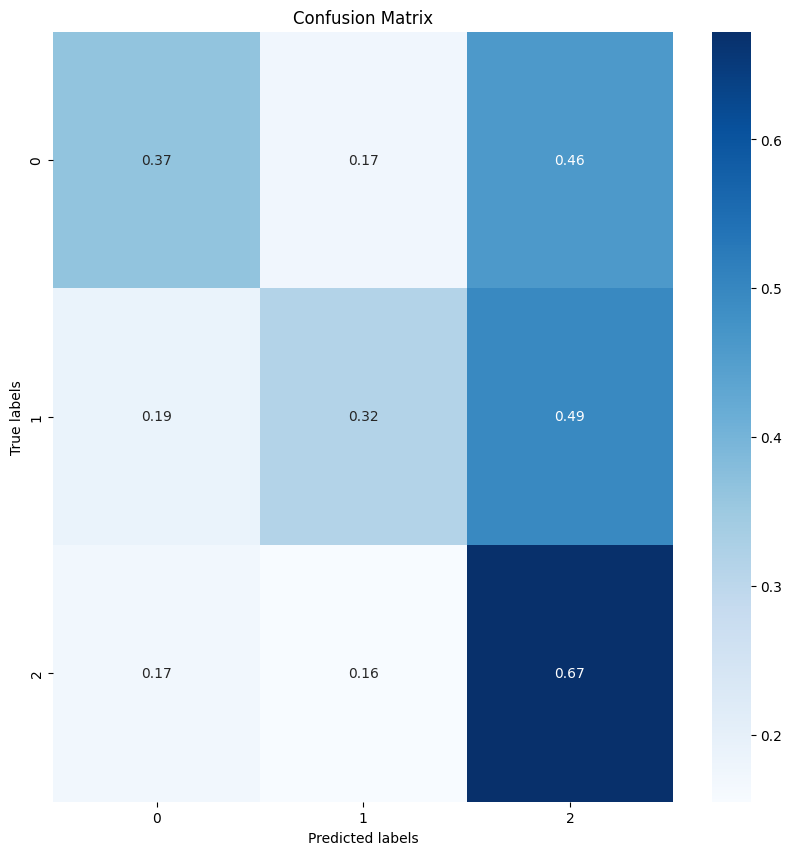

In [ ]:
test_accuracy = 0
all_predictions = []
all_targets = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for (inp, targ, lens) in test_dataset:
        predictions, _ = model(inp.permute(1, 0).to(device), lens)
        batch_accuracy = accuracy(targ.to(device), predictions)
        test_accuracy += batch_accuracy

        # Convert targets to class indices if they are one-hot encoded
        # Assuming targ is one-hot encoded with a shape [batch_size, num_classes]
        targ_indices = torch.argmax(targ.long(), dim=1) if targ.dim() > 1 else targ

        # Collect all true labels and predictions for confusion matrix
        all_targets.extend(targ_indices.view(-1).cpu().numpy())
        all_predictions.extend(torch.argmax(predictions, dim=-1).view(-1).cpu().numpy())

print('Test Accuracy: {:.4f}'.format(test_accuracy / len(test_dataset)))

# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap='Blues', fmt='.2f')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

**Comment**

The effect of the inbalance in the dataset is again becoming visible in this case. The model predicts most of the data to be in the 'positive' category.

**Combined Model**

**Unified dataset**

In [ ]:
class CombinedDataset(Dataset):
    def __init__(self, image_dataset, text_dataset):
        assert len(image_dataset) == len(text_dataset), "Datasets must be of the same size"
        self.image_dataset = image_dataset
        self.text_dataset = text_dataset

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, idx):
        image, image_label = self.image_dataset[idx]
        text_data = self.text_dataset[idx]
        if len(text_data) != 3:
          raise ValueError(f"Expected 3 values from text_dataset, got {len(text_data)}")
        text, _, text_length = text_data

        # No need to combine labels since they are the same, just use image_label
        if not isinstance(image_label, torch.Tensor):
            image_label = torch.tensor(image_label, dtype=torch.float)

        return image, text, image_label, text_length

adjusted_text_dataset = []
for item in input_tensor:
    token_ids = item
    sequence_length = len(token_ids)
    adjusted_item = (token_ids, None, sequence_length)  # Adjust structure
    adjusted_text_dataset.append(adjusted_item)

combined_dataset = CombinedDataset(my_image_dataset, adjusted_text_dataset)

train_size = int(0.7 * len(combined_dataset))
val_size = int(0.15 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

cnn_model = OurCNN()
gru_model = EmoGRU(vocab_inp_size, embedding_dim, units, 30, target_size)
#gru_model = EmoGRU(vocab_size=10000, embedding_dim=256, hidden_units=128, batch_sz=32, output_size=64)

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, cnn_model, gru_model, cnn_output_size, gru_output_size, num_classes):
        super(CombinedModel, self).__init__()
        self.cnn_model = cnn_model
        self.gru_model = gru_model

        # Assuming cnn_output_size and gru_output_size are the sizes of the output features from CNN and GRU respectively
        self.fc1 = nn.Linear(cnn_output_size + gru_output_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, image, text, lens, return_features=False):
        # Process image through CNN
        image_features = self.cnn_model(image, return_features=True)

        # Process text through GRU
        text_features, _ = self.gru_model(text, lens, return_features=True)

        #text_features = text_features[:, -1, :]
        print(len(image_features))
        print(len(text_features))

        # Concatenate the features from both branches
        combined_features = torch.cat((image_features, text_features), dim=1)

        # Pass the combined features through the linear layers
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)

        return x

In [ ]:
# Create the combined model
combined_model = CombinedModel(cnn_model, gru_model, cnn_output_size=64*75*150, gru_output_size=128, num_classes=3)

In [ ]:
import torch.optim as optim


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    combined_model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, texts, labels, lens in train_loader:  # Include text_lengths in unpacking
        optimizer.zero_grad()  # Zero the parameter gradients

        # Now including text_lengths in the model call
        outputs = combined_model(images, texts, lens)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

32
30


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 30 for tensor number 1 in the list.

**Comment**

The problem seems to be related to the dimensions of each feature. More specifically the size of the image features are 30 whereas the size of the text features is 32.